<a href="https://colab.research.google.com/github/cauarichard/crud2/blob/main/facescriadastreino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import copy
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [25]:
# Caminhos no Drive (AJUSTE se necessário)
REAL_DIR = "/content/drive/MyDrive/dataset/real_fake/faces_real_completada"
FAKE_DIR = "/content/drive/MyDrive/dataset/real_fake/faces_fake_completada"

# Target: 100 reais + 100 fakes no total
N_PER_CLASS = 100
N_TRAIN_PER_CLASS = 60   # treino: 60 reais + 60 fakes
N_VAL_PER_CLASS = 40     # validação: 40 reais + 40 fakes

# Onde salvar melhor modelo
SAVE_DIR = "/content/drive/MyDrive/dino_real_fake_tuning"
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(SAVE_DIR, "dino_real_fake_best.pt")
print("Melhor modelo será salvo em:", BEST_MODEL_PATH)

# Hiperparâmetros
BATCH_SIZE = 16          # pequeno, dataset é pequeno
MAX_EPOCHS = 50
LR = 1e-4
PATIENCE = 3
MIN_DELTA = 0.0          # dataset pequeno, aceita qualquer melhora

# Listar arquivos e amostrar 100 de cada
real_files = [os.path.join(REAL_DIR, f) for f in os.listdir(REAL_DIR)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]
fake_files = [os.path.join(FAKE_DIR, f) for f in os.listdir(FAKE_DIR)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]

random.seed(42)
real_files = random.sample(real_files, N_PER_CLASS)
fake_files = random.sample(fake_files, N_PER_CLASS)

print("Reais selecionadas:", len(real_files))
print("Fakes selecionadas:", len(fake_files))


Melhor modelo será salvo em: /content/drive/MyDrive/dino_real_fake_tuning/dino_real_fake_best.pt
Reais selecionadas: 100
Fakes selecionadas: 100


In [26]:
# Split: 60/40 para cada classe
real_train = real_files[:N_TRAIN_PER_CLASS]
real_val   = real_files[N_TRAIN_PER_CLASS:N_TRAIN_PER_CLASS+N_VAL_PER_CLASS]

fake_train = fake_files[:N_TRAIN_PER_CLASS]
fake_val   = fake_files[N_TRAIN_PER_CLASS:N_TRAIN_PER_CLASS+N_VAL_PER_CLASS]

print("Treino - reais:", len(real_train), "fakes:", len(fake_train))
print("Val   - reais:", len(real_val),   "fakes:", len(fake_val))

# Definir transforms (DINO 224x224)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

class RealFakeDataset(Dataset):
    def __init__(self, real_paths, fake_paths, transform=None):
        self.samples = [(p, 0) for p in real_paths] + [(p, 1) for p in fake_paths]
        random.shuffle(self.samples)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = RealFakeDataset(real_train, fake_train, transform=train_transform)
val_dataset   = RealFakeDataset(real_val,   fake_val,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

print("Tamanho treino:", len(train_dataset))
print("Tamanho val:", len(val_dataset))


Treino - reais: 60 fakes: 60
Val   - reais: 40 fakes: 40
Tamanho treino: 120
Tamanho val: 80


In [27]:
!pip install -q timm


In [28]:
import timm

backbone = timm.create_model("vit_small_patch16_224.dino", pretrained=True)

# Remover cabeça original e obter dimensão
if hasattr(backbone, "head") and isinstance(backbone.head, nn.Linear):
    embed_dim = backbone.head.in_features
    backbone.head = nn.Identity()
else:
    backbone.eval()
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 224, 224)
        feats = backbone.forward_features(dummy)
        if isinstance(feats, dict) and "x" in feats:
            feats = feats["x"]
        embed_dim = feats.shape[-1]

classifier = nn.Sequential(
    nn.Linear(embed_dim, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

class DinoRealFake(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        feats = self.backbone.forward_features(x)
        if isinstance(feats, dict) and "x" in feats:
            feats = feats["x"]
        if feats.ndim == 3:
            feats = feats[:, 0]
        return self.head(feats)

    def embed(self, x):
        feats = self.backbone.forward_features(x)
        if isinstance(feats, dict) and "x" in feats:
            feats = feats["x"]
        if feats.ndim == 3:
            feats = feats[:, 0]
        return feats

dino_model = DinoRealFake(backbone, classifier).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dino_model.parameters(), lr=LR, weight_decay=1e-4)

print("DINO pronto. Embedding dim:", embed_dim)


DINO pronto. Embedding dim: 384


In [29]:
import timm

backbone = timm.create_model("vit_small_patch16_224.dino", pretrained=True)

# Remover cabeça original e obter dimensão
if hasattr(backbone, "head") and isinstance(backbone.head, nn.Linear):
    embed_dim = backbone.head.in_features
    backbone.head = nn.Identity()
else:
    backbone.eval()
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 224, 224)
        feats = backbone.forward_features(dummy)
        if isinstance(feats, dict) and "x" in feats:
            feats = feats["x"]
        embed_dim = feats.shape[-1]

classifier = nn.Sequential(
    nn.Linear(embed_dim, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

class DinoRealFake(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        feats = self.backbone.forward_features(x)
        if isinstance(feats, dict) and "x" in feats:
            feats = feats["x"]
        if feats.ndim == 3:
            feats = feats[:, 0]
        return self.head(feats)

    def embed(self, x):
        feats = self.backbone.forward_features(x)
        if isinstance(feats, dict) and "x" in feats:
            feats = feats["x"]
        if feats.ndim == 3:
            feats = feats[:, 0]
        return feats

dino_model = DinoRealFake(backbone, classifier).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dino_model.parameters(), lr=LR, weight_decay=1e-4)

print("DINO pronto. Embedding dim:", embed_dim)


DINO pronto. Embedding dim: 384


In [30]:
# Bloco 5 – função para extrair embeddings da validação

def get_val_embeddings(model, loader):
    model.eval()
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            feats = model.embed(x)   # usa o método .embed do DinoRealFake
            all_feats.append(feats.cpu().numpy())
            all_labels.append(y.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_feats, all_labels


In [31]:
best_val_loss = float("inf")
best_model_state = None
epochs_no_improve = 0

tsne_epoch1 = None
labels_epoch1 = None

for epoch in range(1, MAX_EPOCHS + 1):
    epoch_start = time.time()

    # ===== Treino =====
    dino_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = dino_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        _, preds = torch.max(out, 1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)

    train_loss /= total_train
    train_acc = correct_train / total_train

    # ===== Validação =====
    dino_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = dino_model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            _, preds = torch.max(out, 1)
            correct_val += (preds == y).sum().item()
            total_val += y.size(0)

    val_loss /= total_val
    val_acc = correct_val / total_val

    epoch_time = time.time() - epoch_start
    print(f"Época {epoch}/{MAX_EPOCHS} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}% | "
          f"Tempo: {epoch_time:.1f}s")

    # t-SNE após 1ª época
    if epoch == 1:
        feats1, lab1 = get_val_embeddings(dino_model, val_loader)
        tsne_epoch1 = TSNE(n_components=2, random_state=42, init="random").fit_transform(feats1)
        labels_epoch1 = lab1

    # Early stopping + melhor modelo
    if val_loss < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(dino_model.state_dict())
        epochs_no_improve = 0
        torch.save(best_model_state, BEST_MODEL_PATH)
        print(f"  ↳ Melhorou! Novo best val_loss = {best_val_loss:.4f}. Modelo salvo.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ Sem melhora significativa ({epochs_no_improve}/{PATIENCE}).")

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping ativado na época {epoch}.")
        break

print("\nTreino concluído. Melhor val_loss:", best_val_loss)
print("Melhor modelo salvo em:", BEST_MODEL_PATH)


Época 1/50 | Train loss: 1.5336, acc: 49.17% | Val loss: 0.5657, acc: 93.75% | Tempo: 4.0s
  ↳ Melhorou! Novo best val_loss = 0.5657. Modelo salvo.
Época 2/50 | Train loss: 0.7292, acc: 63.33% | Val loss: 0.5326, acc: 70.00% | Tempo: 7.8s
  ↳ Melhorou! Novo best val_loss = 0.5326. Modelo salvo.
Época 3/50 | Train loss: 0.6811, acc: 63.33% | Val loss: 0.3452, acc: 91.25% | Tempo: 6.2s
  ↳ Melhorou! Novo best val_loss = 0.3452. Modelo salvo.
Época 4/50 | Train loss: 0.4137, acc: 78.33% | Val loss: 0.4065, acc: 83.75% | Tempo: 5.9s
  ↳ Sem melhora significativa (1/3).
Época 5/50 | Train loss: 0.2964, acc: 87.50% | Val loss: 0.2990, acc: 87.50% | Tempo: 4.0s
  ↳ Melhorou! Novo best val_loss = 0.2990. Modelo salvo.
Época 6/50 | Train loss: 0.3516, acc: 84.17% | Val loss: 0.2286, acc: 92.50% | Tempo: 2.6s
  ↳ Melhorou! Novo best val_loss = 0.2286. Modelo salvo.
Época 7/50 | Train loss: 0.3168, acc: 88.33% | Val loss: 0.1462, acc: 93.75% | Tempo: 2.5s
  ↳ Melhorou! Novo best val_loss = 0.1462

In [32]:
# Carregar melhor modelo para extrair embeddings
best_model = DinoRealFake(backbone, classifier).to(DEVICE)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
best_model.eval()

feats_best, labels_best = get_val_embeddings(best_model, val_loader)
tsne_best = TSNE(n_components=2, random_state=42, init="random").fit_transform(feats_best)


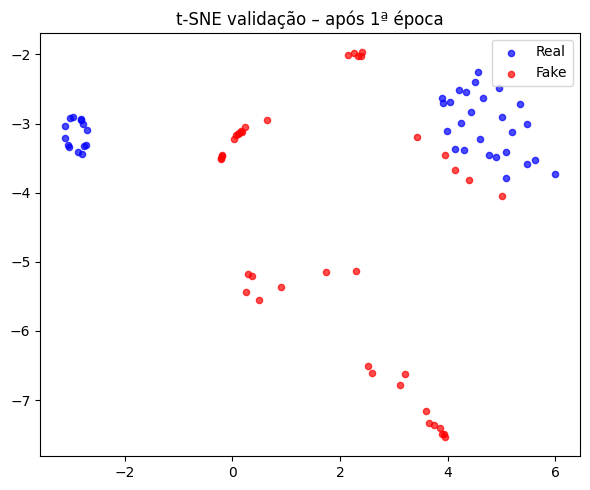

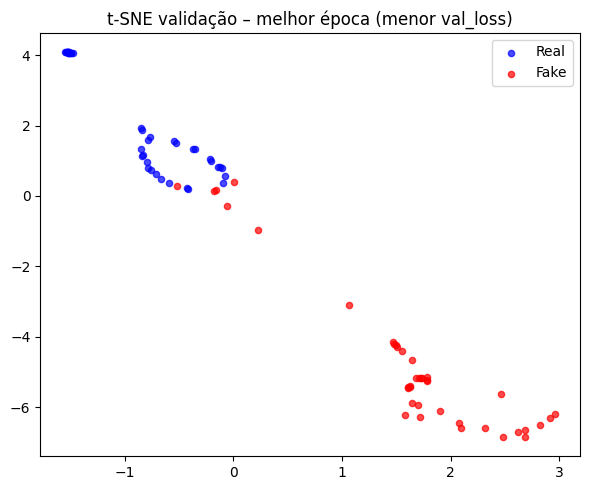

In [33]:
def plot_tsne(tsne_points, labels, title):
    plt.figure(figsize=(6,5))
    for cls, name, color in [(0, "Real", "blue"), (1, "Fake", "red")]:
        idx = labels == cls
        plt.scatter(tsne_points[idx, 0], tsne_points[idx, 1],
                    c=color, label=name, alpha=0.7, s=20)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# t-SNE da 1ª época
plot_tsne(tsne_epoch1, labels_epoch1, "t-SNE validação – após 1ª época")

# t-SNE da melhor época
plot_tsne(tsne_best, labels_best, "t-SNE validação – melhor época (menor val_loss)")
